In [1]:
# Will reload modeules after this when they change!
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

If you look at how we're going to use the fragment match scores, we're in this awkward position where absence of evidence isn't evidence of absence. Even if none of the fragments match, we can't confidently assert that a molecule is unlikely. We can only start to say a molecule is unlikely if we look at all the other options that could explain a peak, and find one or several that are really solid matches.

I envision us ending up with rules like "if there is any molecule A in this annotation with a score 0.X higher than molecule B, mark molecule A as more likely and B as less likely". We would probably want to take p-values into account when defining the 0.X threshold so that we don't overstate certainty when there's only 1 potentially observable fragment per molecule. To make these sorts of coarse judgments, we don't need a precise score that can be compared across a wide variety of annotations, we just need an approximate score that can be compared within a set of relatively similar molecules within the same annotation or isomeric/isobaric set.

Regarding the actual colocalization metric, I don't think we need to go any more advanced than Median-Thresholded Cosine. The "Parent colocalizes with a subset of Fragment" and "Fragment colocalizes with a subset of Parent" both boost confidence a bit, but not as much as full colocalization. Median-Thresholded Cosine (and most other colocalization algorithms) preserve the expected ranking between these classes, so I think it's fine. IMO, if we want to special-case subset-colocalization, we'd need to spend weeks on an experiment to prove we've chosen the right approach. I don't think it would matter much in the big picture, because if we're only comparing within sets of relatively similar molecules, there will be similar numbers of fragments and a lot of the fragments will be common within the set, meaning that any algorithmic biases will be applied fairly evenly across molecules in the same set.

The aspect I know the least about is how to combine multiple fragment colocalization scores into a single score for each molecule. The Enrichment Analysis technique used by MetaboAnalyst seems like it solves an analogous problem, but I haven't looked into the math behind it.

If you need specific numbers for how common Case II and Case III are, I would suggest thresholding both images to make them binary, then calculating how many pixels are set in the area of intersection vs how many pixels are in each thresholded image. Something like this:

In [ ]:
parent_mask = parent_img > np.max(parent_img) / 10
fragment_mask = fragment_img > np.max(fragment_img) / 10
intersection_mask = parent_mask | fragment_mask
parent_size = np.count_nonzero(parent_mask)
fragment_size = np.count_nonzero(fragment_mask)
intersection_size = np.count_nonzero(intersection_mask)
if intersection_size > parent_size / 2 and intersection_size > fragment_size / 2:
    # If more than 50% of both parent and fragment intersect
    return "Case I"
elif intersection_size > parent_size / 2 and parent_size < fragment_size:
    # If more than 50% of parent intersects with fragment, and fragment is bigger
    return "Case II"
elif intersection_size > fragment_size / 2 and parent_size > fragment_size:
    # If more than 50% of fragment intersects with parent, and parent is bigger
    return "Case III"
elif intersection_size < parent_size / 2 and intersection_size < fragment_size / 2:
    # If less than 50% of both fragment & parent intersect
    return "Case IV"
else:
    # The above conditions don't cover all possible combinations...
    return "Some other case"

In [ ]:
Median-thresholded cosine

https://github.com/metaspace2020/coloc/blob/master/measures/NoLearning/ion_intensity_coloc_measures.ipynb

https://github.com/metaspace2020/metaspace/blob/2b1066efa0cc1bc68459cca1a41b9ae7d598cbf3/metaspace/engine/sm/engine/colocalization.py#L211

In [4]:
def metaspace_hotspot_removal(img):
    awkwardness = np.max(img) / 255
    hot_thresold = np.percentile(img[img >= awkwardness], 99) or 1
    return np.clip(img, 0, hot_thresold) / hot_thresold

In [5]:
def compute_median_threshold_cosine(img_a, img_b):
    img_a = metaspace_hotspot_removal(imag_a)
    img_b = metaspace_hotspot_removal(imag_b)
    
    # median filter window size
    med_win = 3
    if med_win > 0: 
        img = ndimage.median_filter(img, med_win)
    
    

The h and w parameters are included because a and b were both passed in as 1D arrays in that codebase, but the algorithm requires 2D images. If your images are already 2D you could remove the two `reshape`s and not need to pass the h and w through

In [6]:
def get_median_filtered_coloc(a, b, h, w):
    def preprocess(img):
        img = img.copy().reshape((h, w))
        img[img < np.quantile(img, 0.5)] = 0
        return median_filter(img, (3, 3)).reshape([1, h*w])
    return cosine_similarity(preprocess(a), preprocess(b))[0,0]

In [18]:
from scipy.ndimage import median_filter
from sklearn.metrics.pairwise import cosine_similarity
import imageio

def get_median_filtered_coloc(a, b):
    # Modified for input as 2D image
    def preprocess(img):
        img = img.copy()
        img[img < np.quantile(img, 0.5)] = 0
        return median_filter(img, (3, 3))
    return cosine_similarity(preprocess(a), preprocess(b))[0,0]

In [27]:
a = '/Users/dis/PycharmProjects/word2vec/METASPACE_img_df_2020_May_18_spotted_9x/2020-05-14_16h32m01s/by_id/HMDB0008578/C30H59NO6P_F.png'

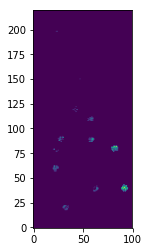

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy.cluster.vq as scv


def colormap2arr(arr,cmap):    
    # http://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values/3722674#3722674
    gradient=cmap(np.linspace(0.0,1.0,100))

    # Reshape arr to something like (240*240, 4), all the 4-tuples in a long list...
    arr2=arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2]))

    # Use vector quantization to shift the values in arr2 to the nearest point in
    # the code book (gradient).
    code,dist=scv.vq(arr2,gradient)

    # code is an array of length arr2 (240*240), holding the code book index for
    # each observation. (arr2 are the "observations".)
    # Scale the values so they are from 0 to 1.
    values=code.astype('float')/gradient.shape[0]

    # Reshape values back to (240,240)
    values=values.reshape(arr.shape[0],arr.shape[1])
    values=values[::-1]
    return values

arr=plt.imread(a)
values=colormap2arr(arr,cm.viridis)    

# Proof that it works:
plt.imshow(values,interpolation='bilinear', cmap=cm.viridis,
           origin='lower')
plt.show()

In [45]:
values=colormap2arr(plt.imread(a),cm.viridis)

a = '/Users/dis/PycharmProjects/word2vec/METASPACE_img_df_2020_May_18_spotted_9x/2020-05-14_16h32m01s/by_id/HMDB0008578/C30H59NO6P_F.png'
b = '/Users/dis/PycharmProjects/word2vec/METASPACE_img_df_2020_May_18_spotted_9x/2020-05-14_16h32m01s/by_id/HMDB0008578/C47H87O4_F.png'
get_median_filtered_coloc(colormap2arr(plt.imread(a),cm.viridis),
                          colormap2arr(plt.imread(b),cm.viridis))

0.0

In [ ]:
# Task: Assemble list of questions/queries/approaches

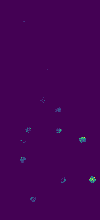

In [48]:
import pathlib
from PIL import Image
dir_path = pathlib.Path("/home/intsco/Downloads")
image_path = dir_path / "image.png"
image = Image.open(a)
image

In [49]:
image.size, image.mode

((100, 220), 'RGBA')

In [55]:
c = pd.read_pickle('/Users/dis/PycharmProjects/word2vec/METASPACE_img_df_2020_May_19_spotted_9x_arr/2020-05-14_16h32m01s/by_formula/C5H14NO.pickle').to_numpy()
d = pd.read_pickle('/Users/dis/PycharmProjects/word2vec/METASPACE_img_df_2020_May_19_spotted_9x_arr/2020-05-14_16h32m01s/by_formula/C52H101NO8P.pickle').to_numpy()

In [56]:
c

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [62]:
c.shape

(220, 100)

In [57]:
d

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [63]:
d.shape

(220, 100)

In [58]:
get_median_filtered_coloc(c,d)

0.0

In [59]:
get_median_filtered_coloc(c,c)

0.0

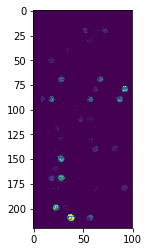

In [60]:
plt.imshow(c)

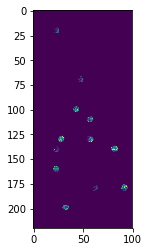

In [61]:
plt.imshow(d)